# 2. Data representation heatmap

This notebook visualizes a heatmap to compare how various data representations capture information within the dataset. Specifically, it demonstrates how aggregation methods applied to single-cell populations can reduce or obscure informative signals. By leveraging centroids generated from single-cell profiles, we highlight the differences in information retention and illustrate the impact of aggregation on downstream analyses.

In [1]:
# Load required libraries
suppressPackageStartupMessages({
    library(tidyverse)
    library(arrow)
    library(jsonlite)
    library(pheatmap)
    library(RColorBrewer)
    library(viridis)
    library(ComplexHeatmap)
    library(circlize)
    library(grid)
    library(magick)
})

In [2]:
# Set random seed for reproducibility
set.seed(0)

cat("Libraries loaded successfully\n")

Libraries loaded successfully


set input and output paths

In [3]:
# Define directory paths
module_results_path <- file.path("..", "results")

# Input paths
signatures_path <- file.path(module_results_path, "signatures", "cfret_pilot_signatures.json")
consensus_profiles_path <- file.path(module_results_path, "aggregate_profiles", "cfret_consensus_profiles.parquet")
replicates_profiles_path <- file.path(module_results_path, "aggregate_profiles", "cfret_replicate_profiles.parquet")
single_cell_centroids_path <- file.path(module_results_path, "centroids", "cfret_pilot_centroids.parquet")

# check if input files and directories exist
if (!dir.exists(module_results_path)) stop("Module results directory not found")
if (!file.exists(signatures_path)) stop("Signatures file not found")
if (!file.exists(single_cell_centroids_path)) stop("Single-cell centroids file not found")

# Check which profile files exist and raise errors if not found
has_consensus <- file.exists(consensus_profiles_path)
has_replicates <- file.exists(replicates_profiles_path)
has_centroids <- file.exists(single_cell_centroids_path)

if (!has_consensus) stop("Consensus profiles file not found")
if (!has_replicates) stop("Replicates profiles file not found")
if (!has_centroids) stop("Single-cell centroids file not found")

if (!has_consensus) {
    cat("Note: Consensus profiles file not found, will continue without it\n")
}
if (!has_replicates) stop("Replicates profiles file not found")
if (!has_centroids) stop("Single-cell centroids file not found")

# Output directory structure
figures_dir <- file.path(".", "figures")

# Create output directories
dir.create(figures_dir, showWarnings = FALSE, recursive = TRUE)

cat("Directory structure verified\n")

Directory structure verified


Load the on- and off-target signatures and the profiles of different representations, then select important metadata for the heatmap.

In [4]:
# Important metadata to select from all profiles
selected_metadata <- c("Metadata_heart_treatment", "Metadata_datatype")

# Load signatures
signatures_dict <- fromJSON(signatures_path)
on_signature <- signatures_dict$on
off_signature <- signatures_dict$off

# Load profiles - the parquet files have been fixed to remove dictionary encoding
# Load only the files that exist
profile_list <- list()

if (has_consensus) {
    consensus_profiles_df <- read_parquet(consensus_profiles_path, as_data_frame = TRUE)
    consensus_profiles_df <- consensus_profiles_df %>%
        mutate(Metadata_datatype = paste0("consensus_", row_number())) %>%
        select(all_of(c(selected_metadata, on_signature, off_signature)))
    profile_list[[length(profile_list) + 1]] <- consensus_profiles_df
}

if (has_replicates) {
    replicates_profiles_df <- read_parquet(replicates_profiles_path, as_data_frame = TRUE)
    replicates_profiles_df <- replicates_profiles_df %>%
        mutate(Metadata_datatype = paste0("replicates_", row_number())) %>%
        select(all_of(c(selected_metadata, on_signature, off_signature)))
    profile_list[[length(profile_list) + 1]] <- replicates_profiles_df
}

if (has_centroids) {
    single_cell_centroids_df <- read_parquet(single_cell_centroids_path, as_data_frame = TRUE)
    single_cell_centroids_df <- single_cell_centroids_df %>%
        mutate(Metadata_datatype = paste0("single_cell_centroids_", row_number())) %>%
        select(all_of(c(selected_metadata, on_signature, off_signature)))
    profile_list[[length(profile_list) + 1]] <- single_cell_centroids_df
}

# Concatenate all available profiles
all_profiles_df <- bind_rows(profile_list)

# Split "Metadata_heart_treatment" into two columns
all_profiles_df <- all_profiles_df %>%
    separate(Metadata_heart_treatment, 
             into = c("Metadata_heart_phenotype", "Metadata_treatment"),
             sep = "_",
             remove = TRUE)

# Print shapes
if (has_consensus) cat("Consensus profiles shape:", nrow(consensus_profiles_df), "×", ncol(consensus_profiles_df), "\n")
if (has_replicates) cat("Replicates profiles shape:", nrow(replicates_profiles_df), "×", ncol(replicates_profiles_df), "\n")
if (has_centroids) cat("Single-cell centroids shape:", nrow(single_cell_centroids_df), "×", ncol(single_cell_centroids_df), "\n")
cat("Concatenated profiles shape:", nrow(all_profiles_df), "×", ncol(all_profiles_df), "\n")

Consensus profiles shape: 4 × 659 
Replicates profiles shape: 33 × 659 
Single-cell centroids shape: 9 × 659 
Concatenated profiles shape: 46 × 660 


## Plotting data representations clustermap

setting plot configurations

In [5]:
# Heatmap dimensions
heatmap_width <- 12
heatmap_height <- 10

# Font sizes for publication
title_size <- 14
legend_size <- 9
label_size <- 10

# Color scheme configuration
# Using consistent color palettes suitable for publication
set1_palette <- brewer.pal(9, "Set1")
dark2_palette <- brewer.pal(8, "Dark2")
paired_palette <- brewer.pal(12, "Paired")
pastel2_palette <- brewer.pal(8, "Pastel2")

# setting notebook render options 
options(
    repr.plot.width = heatmap_width,
    repr.plot.height = heatmap_height
)
# Prepare data matrix
# Set row names to Metadata_datatype
data_for_heatmap <- all_profiles_df %>%
    column_to_rownames("Metadata_datatype")

# Extract metadata
metadata <- data_for_heatmap %>%
    select(Metadata_heart_phenotype, Metadata_treatment) %>%
    mutate(Metadata_representation = str_extract(rownames(.), "^[^_]+(?:_[^_]+)*(?=_\\d+$)"))

# Debug: Check phenotypes
unique_phenos <- unique(metadata$Metadata_heart_phenotype)
cat("Found phenotypes:", paste(unique_phenos, collapse = ", "), "\n")

# Prepare feature matrix (transpose for heatmap: rows=features, cols=samples)
feature_data <- data_for_heatmap %>%
    select(all_of(c(on_signature, off_signature)))

data_matrix <- t(as.matrix(feature_data))

Found phenotypes: failing, healthy 


Defining color mappings

In [6]:
# Define awtools-inspired darker color palette
# Based on awtools a_palette with richer, darker colors
awtools_colors <- c(
    "#c1593c",  # Terracotta
    "#643d91",  # Purple
    "#a19e3d",  # Olive
    "#0e7175",  # Teal
    "#e6842c",  # Orange
    "#3e6d9c",  # Blue
    "#4e3629",  # Brown
    "#b40000",  # Red
    "#2d7016",  # Green
    "#8b6f47",  # Tan
    "#5c415d",  # Plum
    "#1e5a46"   # Forest
)

# Phenotype colors using darker palette
color_prefs <- list(
    Failing = awtools_colors[8],    # Red
    Healthy = awtools_colors[9],    # Green
    Rescue = awtools_colors[6]      # Blue
)

# Create phenotype color map
pheno_colors <- sapply(unique_phenos, function(label) {
    label_lower <- tolower(as.character(label))
    if (grepl("fail", label_lower)) {
        return(color_prefs$Failing)
    } else if (grepl("health", label_lower)) {
        return(color_prefs$Healthy)
    } else if (grepl("rescue", label_lower)) {
        return(color_prefs$Rescue)
    } else {
        return("#4e3629")  # Brown for unknowns
    }
})
names(pheno_colors) <- unique_phenos

# Treatment colors using darker tones
unique_treatments <- unique(metadata$Metadata_treatment)
treat_colors <- setNames(
    awtools_colors[1:length(unique_treatments)],
    unique_treatments
)

# Representation colors using dark2 palette
unique_representations <- unique(metadata$Metadata_representation)
repr_colors <- setNames(
    dark2_palette[1:length(unique_representations)],
    unique_representations
)

# Column annotations
col_annotations <- HeatmapAnnotation(
    Phenotype = metadata$Metadata_heart_phenotype,
    Treatment = metadata$Metadata_treatment,
    Representation = metadata$Metadata_representation,
    col = list(
        Phenotype = pheno_colors,
        Treatment = treat_colors,
        Representation = repr_colors
    ),
    annotation_name_gp = gpar(fontsize = label_size, fontface = "bold"),
    annotation_legend_param = list(
        Phenotype = list(title_gp = gpar(fontsize = legend_size, fontface = "bold")),
        Treatment = list(title_gp = gpar(fontsize = legend_size, fontface = "bold")),
        Representation = list(title_gp = gpar(fontsize = legend_size, fontface = "bold"))
    ),
    show_annotation_name = TRUE
)

# Row colors (features) - using darker colors
row_colors_map <- list(
    `ON signature` = awtools_colors[5],   # Orange
    `OFF signature` = awtools_colors[2]   # Purple
)

feature_types <- ifelse(
    rownames(data_matrix) %in% on_signature,
    "ON signature",
    "OFF signature"
)

row_annotations <- rowAnnotation(
    Features = feature_types,
    col = list(Features = c(
        `ON signature` = row_colors_map$`ON signature`,
        `OFF signature` = row_colors_map$`OFF signature`
    )),
    annotation_name_gp = gpar(fontsize = label_size, fontface = "bold"),
    annotation_legend_param = list(
        Features = list(title_gp = gpar(fontsize = legend_size, fontface = "bold"))
    ),
    show_annotation_name = TRUE
)

# Define color function for heatmap
col_fun <- colorRamp2(
    c(min(data_matrix, na.rm = TRUE), 0, max(data_matrix, na.rm = TRUE)),
    c("#2166AC", "#F7F7F7", "#B2182B")  # Blue-White-Red (RdBu_r equivalent)
)


Creating a heatmap

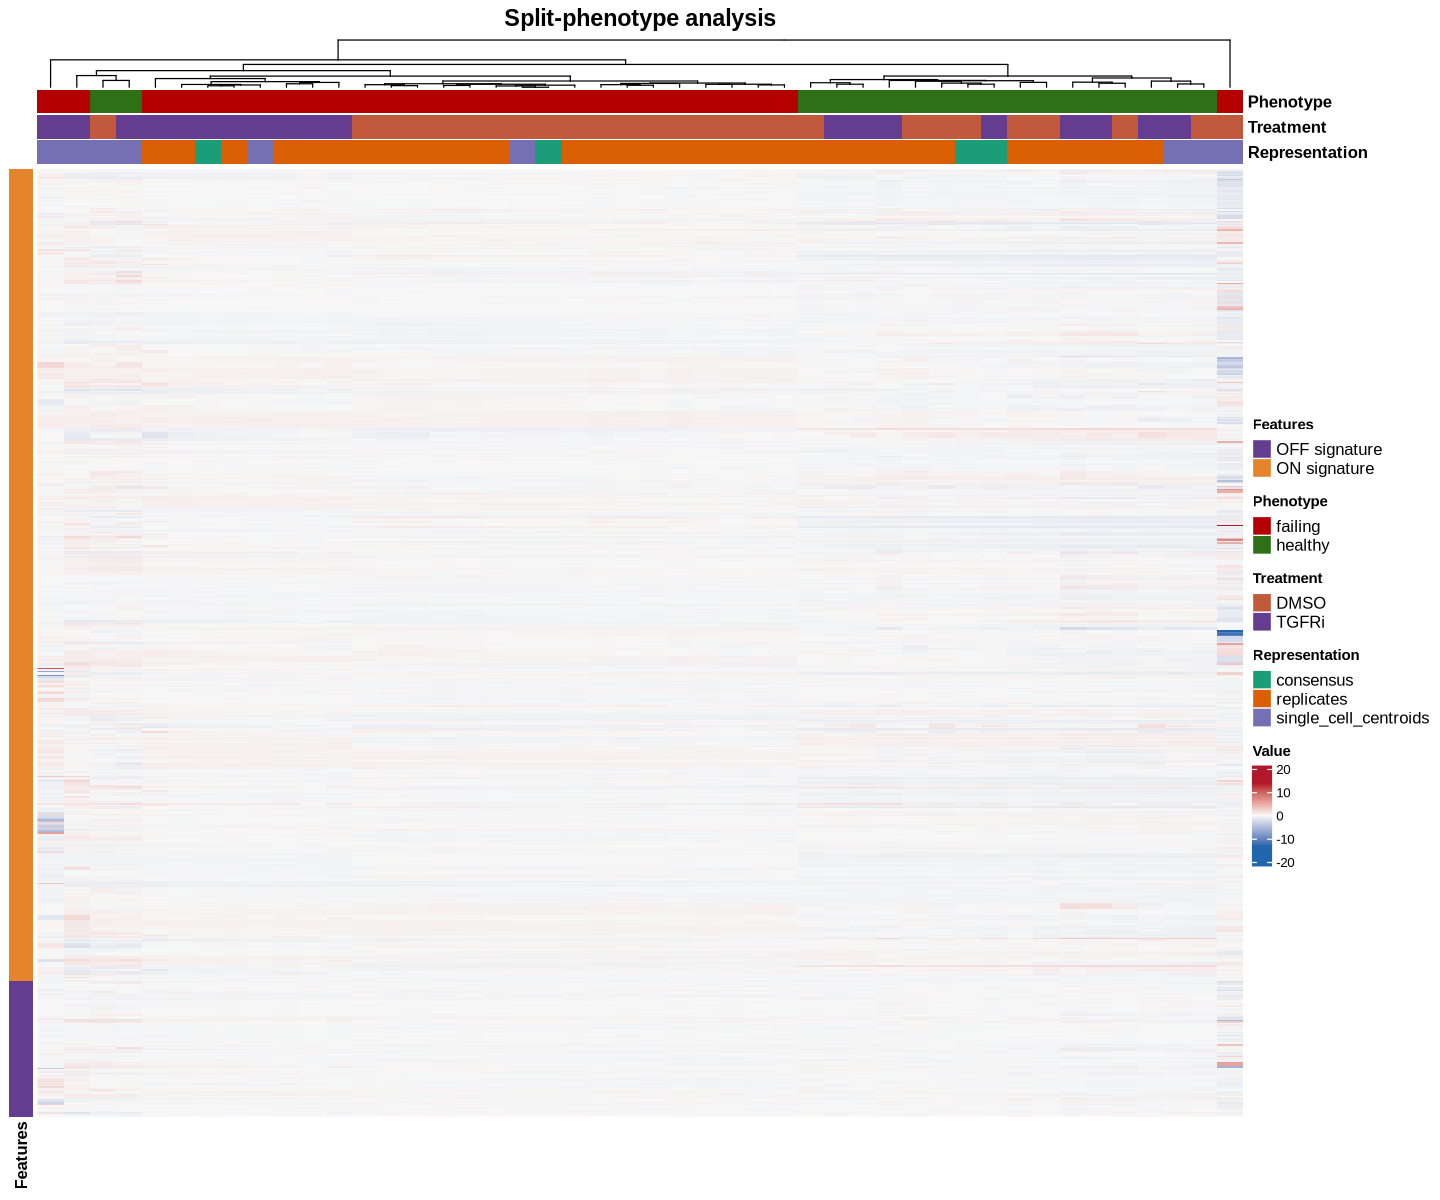

In [7]:
# Create the heatmap
ht <- Heatmap(
    data_matrix,
    name = "Value",
    col = col_fun,
    
    # Clustering
    cluster_columns = TRUE,
    cluster_rows = FALSE,
    clustering_distance_columns = "euclidean",
    clustering_method_columns = "complete",
    
    # Annotations
    top_annotation = col_annotations,
    left_annotation = row_annotations,
    
    # Labels
    show_row_names = FALSE,
    show_column_names = FALSE,
    column_title = "Split-phenotype analysis",
    column_title_gp = gpar(fontsize = title_size, fontface = "bold"),
    
    # Legend
    heatmap_legend_param = list(
        title = "Value",
        title_gp = gpar(fontsize = legend_size, fontface = "bold"),
        labels_gp = gpar(fontsize = legend_size - 1)
    ),
    
    # Performance
    use_raster = TRUE,
    raster_quality = 5
)

# Display the heatmap
draw(ht, 
     heatmap_legend_side = "right",
     annotation_legend_side = "right",
     merge_legend = TRUE)

In [8]:
# Save heatmap as PNG
png(
    filename = file.path(figures_dir, "data_rep_heatmap.png"),
    width = 12,
    height = 10,
    units = "in",
    res = 300,
    bg = "white"
)
draw(ht, 
     heatmap_legend_side = "right",
     annotation_legend_side = "right",
     merge_legend = TRUE)
dev.off()

# Save heatmap as PDF
pdf(
    file = file.path(figures_dir, "data_rep_heatmap.pdf"),
    width = 12,
    height = 10,
    bg = "white"
)
draw(ht, 
     heatmap_legend_side = "right",
     annotation_legend_side = "right",
     merge_legend = TRUE)
dev.off()

cat("Saved heatmap to:", figures_dir, "\n")

agg_record_911124181 
                   2

agg_record_911124181 
                   2

Saved heatmap to: ./figures 
